In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
import xml.etree.ElementTree as ET


import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Create Model

In [2]:
labels = open('../input/yolo-weights-for-licence-plate-detector/classes.names').read()
print(labels)

LP



In [3]:
weights_path = '../input/yolo-weights-for-licence-plate-detector/lapi.weights'
configuration_path = '../input/yolo-weights-for-licence-plate-detector/darknet-yolov3.cfg'

probability_minimum = 0.5
threshold = 0.3

In [4]:
network = cv2.dnn.readNetFromDarknet(configuration_path, weights_path)
layers_names_all = network.getLayerNames()
layers_names_output = [layers_names_all[i[0]-1] for i in network.getUnconnectedOutLayers()]

# Inference

In [5]:
def inference(image_input_paths):
    preds = []
    for path in tqdm(image_input_paths):
        image_input = cv2.imread(path)
        blob = cv2.dnn.blobFromImage(image_input, 1/255.0, (416,416), swapRB=True, crop=False)
        blob_to_show = blob[0,:,:,:].transpose(1,2,0)
        network.setInput(blob)
        output_from_network = network.forward(layers_names_output)
        np.random.seed(42)
        colours = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')

        bounding_boxes = []
        confidences = []
        class_numbers = []
        h,w = image_input.shape[:2]

        for result in output_from_network:
            for detection in result:
                scores = detection[5:]
                class_current = np.argmax(scores)
                confidence_current = scores[class_current]
                if confidence_current > probability_minimum:
                    box_current = detection[0:4] * np.array([w, h, w, h])
                    x_center, y_center, box_width, box_height = box_current.astype('int')
                    x_min = int(x_center-(box_width/2))
                    y_min = int(y_center-(box_height/2))
                    bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
                    confidences.append(float(confidence_current))
                    class_numbers.append(class_current)

        results = cv2.dnn.NMSBoxes(bounding_boxes, confidences, probability_minimum, threshold)

        pred = [0, 0, 0, 0] 
        if len(results) > 0:
            for i in results.flatten():
                x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
                box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]
                pred[0] = x_min
                pred[1] = y_min
                pred[2] = x_min+box_width
                pred[3] = y_min+box_height
                break
                """
                colour_box_current = [int(j) for j in colours[class_numbers[i]]]
                cv2.rectangle(image_input, (x_min, y_min), (x_min + box_width, y_min + box_height),
                              colour_box_current, 5)
                text_box_current = '{}: {:.4f}'.format(labels[int(class_numbers[i])], confidences[i])
                cv2.putText(image_input, text_box_current, (x_min, y_min - 7), cv2.FONT_HERSHEY_SIMPLEX,
                            1.5, colour_box_current, 5)
                """
        preds.append(pred)
    return np.array(preds)

In [6]:
p = "../input/iranvehicleplatedataset/Vehicle Plates/Vehicle Plates"
image_paths = []
for path in sorted(os.listdir(p)):
    image_paths.append(os.path.join(p,path))
    
image_paths[0]

'../input/iranvehicleplatedataset/Vehicle Plates/Vehicle Plates/191.png'

In [7]:
preds = inference(image_paths)
preds.shape

100%|██████████| 313/313 [03:45<00:00,  1.39it/s]


(313, 4)

In [8]:
# reads bounding box coordinates from xml_file with pascal voc format
def read_content(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    for boxes in root.iter('object'):
        ymin, xmin, ymax, xmax = None, None, None, None
        # /IMG_SIZE to normalize it between 0 and 1
        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)
        list_with_single_boxes = [xmin, ymin, xmax, ymax]
    return list_with_single_boxes

def get_gts():
    annot_paths = "../input/iranvehicleplatedataset/Vehicle Plates annotations/Vehicle Plates annotations"
    gts = []
    for filename in sorted(os.listdir(annot_paths)):
        gts.append(read_content(os.path.join(annot_paths, filename)))
    return np.array(gts)

gts = get_gts()
gts.shape

(313, 4)

In [9]:
# computes intersection over union metric
def compute_iou(preds, gts):
    ious = []
    for boxA, boxB in zip(preds, gts):
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])
        # compute the area of intersection rectangle
        interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
        # compute the area of both the prediction and ground-truth
        # rectangles
        boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
        boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
        # compute the intersection over union by taking the intersection
        # area and dividing it by the sum of prediction + ground-truth
        # areas - the interesection area
        iou = interArea / float(boxAArea + boxBArea - interArea)
        ious.append(iou)
    return np.mean(ious)


iou = compute_iou(preds, gts)
iou

0.5598559233581455

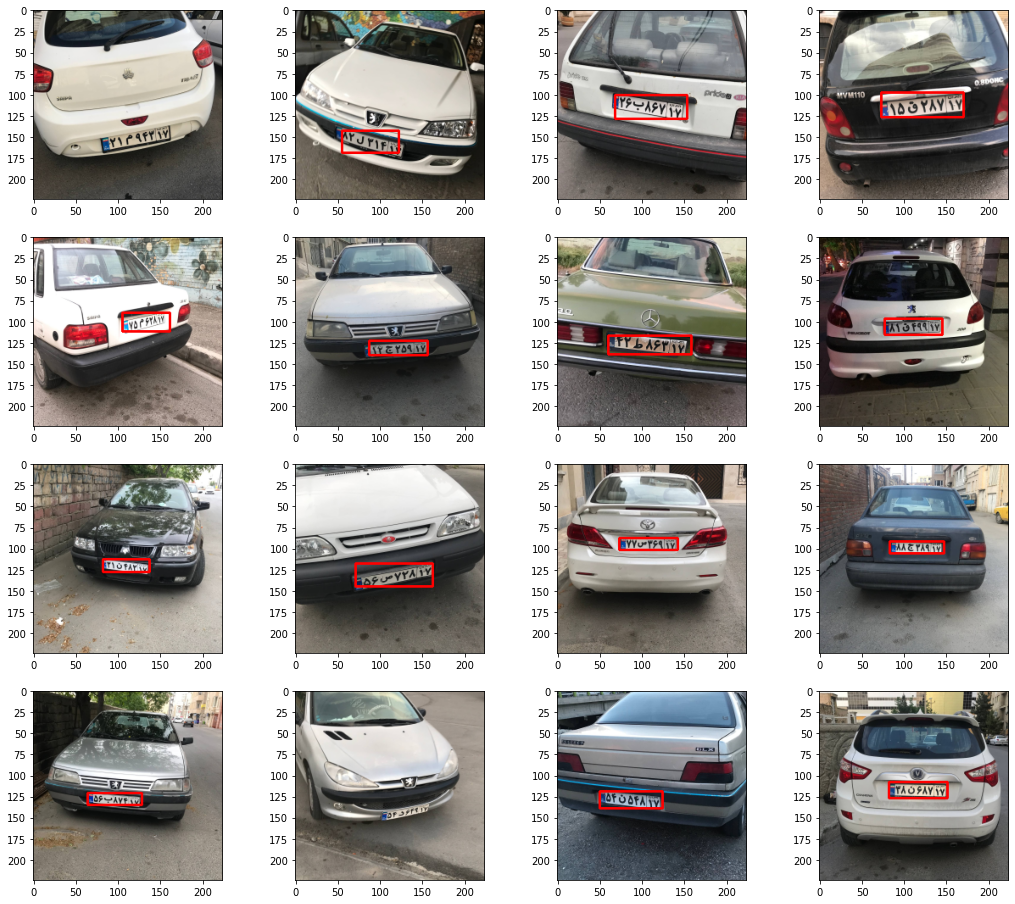

In [10]:
def plot_images(im_paths, gtruths, number=16):
    images = []
    for p in im_paths:
        images.append(cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB))
        
    images = np.array(images)
    gts = gtruths.copy()
    if number < 4:
        number = 4
    columns = 4
    rows = number//columns if number%columns==0 else number//columns + 1
    fig = plt.figure(figsize=(18,rows*4))
    shuffle = np.random.permutation(images.shape[0])
    images = images[shuffle]
    gts = gts[shuffle]
    for index,im in enumerate(images[:number]):
        fig.add_subplot(rows, columns, index+1)
        tmp = im.copy()
        tmp = cv2.rectangle(tmp, (int(gts[index][0]), int(gts[index][1])), (int(gts[index][2]), int(gts[index][3])), (255, 0, 0), 2)
        plt.imshow(tmp)
    plt.show()
    
plot_images(image_paths, preds)